In [1]:
from tqdm import tqdm
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from collections import deque
import gym

import torch
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

# configure module & syspath
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.agents import DoubleDQN as DDQN
from src.agents import DQN as DQN

from src.policies import CartPolePolicy
from src.replays import VanillaReplay

In [2]:
def init_dqn():
    cart_pole_env = gym.make('CartPole-v1')
    policy = CartPolePolicy(cart_pole_env.observation_space.shape[0], cart_pole_env.action_space.n)
    replay_memory = VanillaReplay(capacity = 500)
    optimizer = Adam(policy.parameters(), lr = 0.001)

    return DQN(
      env = cart_pole_env,
      policy = policy,
      replay_memory = replay_memory,
      replay_size = 32,
      min_replay_history = 200,
      optimizer = optimizer,
      discount_rate = 0.999,
      max_epsilon = 1.,
      min_epsilon = 0.1,
      epsilon_decay = 1e-3,
      target_update_steps = 10,
    )

In [3]:
def init_ddqn():
    cart_pole_env = gym.make('CartPole-v1')
    policy = CartPolePolicy(cart_pole_env.observation_space.shape[0], cart_pole_env.action_space.n)
    replay_memory = VanillaReplay(capacity = 500)
    optimizer = Adam(policy.parameters(), lr = 0.001)

    return DDQN(
      env = cart_pole_env,
      policy = policy,
      replay_memory = replay_memory,
      replay_size = 32,
      min_replay_history = 200,
      optimizer = optimizer,
      discount_rate = 0.999,
      max_epsilon = 1.,
      min_epsilon = 0.1,
      epsilon_decay = 1e-3,
      target_update_steps = 10,
    )

In [4]:
max_episodes = 250

rewards_mean_dqn_all = dict()
rewards_median_dqn_all = dict()

rewards_mean_ddqn_all = dict()
rewards_median_ddqn_all = dict()

for i in range(10):
    dqn = init_dqn()
    ddqn = init_ddqn()

    rewards_previous_dqn = deque()
    plt_rewards_mean_dqn = list()
    plt_rewards_median_dqn = list()

    rewards_previous_ddqn = deque()
    plt_rewards_mean_ddqn = list()
    plt_rewards_median_ddqn = list()

    for epi in tqdm(range(max_episodes)):
        # DQN
        episode_transitions_dqn = dqn.play_episode(tune = True)
        rewards_previous_dqn.append(np.sum(list(zip(*episode_transitions_dqn))[2]))
        median_reward_dqn = np.median(rewards_previous_dqn)
        mean_reward_dqn = np.median(rewards_previous_dqn)
        plt_rewards_median_dqn.append(median_reward_dqn)
        plt_rewards_mean_dqn.append(mean_reward_dqn)

        # DDQN
        episode_transitions_ddqn = ddqn.play_episode(tune = True)
        rewards_previous_ddqn.append(np.sum(list(zip(*episode_transitions_ddqn))[2]))
        median_reward_ddqn = np.median(rewards_previous_ddqn)
        mean_reward_ddqn = np.median(rewards_previous_ddqn)
        plt_rewards_median_ddqn.append(median_reward_ddqn)
        plt_rewards_mean_ddqn.append(mean_reward_ddqn)

        if len(rewards_previous_ddqn) == 5:
            rewards_previous_ddqn.popleft()
            rewards_previous_dqn.popleft()
            pass

        if median_reward_dqn > 190. or median_reward_ddqn > 190.:
            break
    
    # save previous runs.
    rewards_mean_dqn_all[i] = plt_rewards_mean_dqn
    rewards_median_dqn_all[i] = plt_rewards_median_dqn
    rewards_mean_ddqn_all[i] = plt_rewards_mean_ddqn
    rewards_median_ddqn_all[i] = plt_rewards_median_ddqn
    continue

 13%|█████████████████████████████                                                                                                                                                                                                      | 32/250 [03:02<20:42,  5.70s/it]


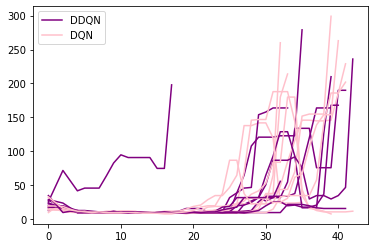

In [10]:
for i in range(10):
    dqn_mean = rewards_mean_dqn_all[i]
    ddqn_mean = rewards_mean_ddqn_all[i]

    if i == 0:
        plt.plot(ddqn_mean, color='purple', label='DDQN')
        plt.plot(dqn_mean, color='pink', label='DQN')
    else:
        plt.plot(ddqn_mean, color='purple')
        plt.plot(dqn_mean, color='pink')
        pass

# titles / legends
plt.legend()
plt.show()